
# 🚀 Clasificador de Flores con Transfer Learning y Data Augmentation

Este notebook implementa un flujo de trabajo completo para construir, entrenar y evaluar un modelo de clasificación de imágenes de flores. El objetivo es aplicar técnicas avanzadas de Deep Learning para lograr una alta precisión en la identificación de diferentes especies de flores.

**Objetivos Clave:**

1.  **Modelo Base:** Utilizar `EfficientNetB0`, una arquitectura convolucional de última generación, pre-entrenada en el dataset ImageNet.
2.  **Dataset:** Emplear el conjunto de datos "flower\_photos" de TensorFlow, que contiene 5 clases de flores.
3.  **Técnicas Avanzadas:**
      * **Transfer Learning:** Aprovechar el conocimiento aprendido por `EfficientNetB0` para acelerar el entrenamiento y mejorar el rendimiento.
      * **Data Augmentation:** Generar nuevas imágenes de entrenamiento mediante transformaciones aleatorias para reducir el sobreajuste (*overfitting*) y mejorar la capacidad de generalización del modelo.
      * **Fine-Tuning:** Realizar un ajuste fino de las capas superiores del modelo pre-entrenado para adaptarlas específicamente a nuestro problema.
4.  **Visualización y Evaluación:** Analizar el rendimiento del modelo a través de métricas gráficas, una matriz de confusión y la visualización de predicciones.

El proyecto está estructurado en pasos lógicos, desde la configuración inicial y el análisis de datos hasta el entrenamiento avanzado y la evaluación final.

-----

### **Configuración del Entorno y Descarga de Datos**

Esta celda inicial se encarga de preparar el entorno de trabajo. Importamos las librerías necesarias (`TensorFlow`, `NumPy`, `Matplotlib`), establecemos semillas aleatorias para garantizar la reproducibilidad de los resultados y verificamos la configuración del sistema, como la versión de TensorFlow y la disponibilidad de una GPU. Finalmente, descargamos y descomprimimos el dataset de flores directamente desde el repositorio de TensorFlow.

In [1]:
# ==============================================================================
# Celda 1: Configuración, importaciones y descarga del dataset
# ==============================================================================

# Importar las librerías fundamentales
import tensorflow as tf         # El framework principal para deep learning
import numpy as np              # Para operaciones numéricas eficientes
import matplotlib.pyplot as plt # Para visualización de datos y resultados
import pathlib                  # Para manejar rutas de archivos de forma orientada a objetos
import os                       # Para interactuar con el sistema operativo
from collections import Counter # Para contar elementos en una colección (ej. etiquetas)
import seaborn as sns           # Para visualizaciones estadísticas más atractivas (ej. matriz de confusión)
from sklearn.metrics import confusion_matrix, classification_report # Herramientas para evaluación

# --- Configuración para la Reproducibilidad ---
# Establecer semillas aleatorias para que los resultados sean consistentes entre ejecuciones
tf.random.set_seed(42)
np.random.seed(42)

# --- Verificación del Entorno ---
# Imprimir la versión de TensorFlow para asegurar compatibilidad
print(f"Versión de TensorFlow: {tf.__version__}")
# Comprobar si hay una GPU disponible, lo que acelera masivamente el entrenamiento
print(f"GPU disponible: {len(tf.config.list_physical_devices('GPU')) > 0}")

# --- Descarga del Dataset ---
# URL del archivo comprimido con las imágenes de flores
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# Descargar y descomprimir el archivo. Keras lo guarda en un caché local.
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
# Convertir la ruta de texto a un objeto Path de pathlib para un manejo más fácil
data_dir = pathlib.Path(data_dir)

# --- Verificación del Dataset Descargado ---
# ==============================================================================
# Diagnóstico y Corrección Automática de la Ruta del Dataset
# ==============================================================================

print(f"Ruta inicial del dataset: {data_dir}")

# Contar los elementos dentro del directorio de datos
items_in_datadir = os.listdir(data_dir)
# Comprobar si solo hay un elemento y si ese elemento es un directorio con el mismo nombre
if len(items_in_datadir) == 1 and os.path.isdir(os.path.join(data_dir, items_in_datadir[0])):
    print("Se detectó una estructura de directorio anidada. Corrigiendo la ruta...")
    # Actualizar data_dir para que apunte a la subcarpeta interna
    data_dir = data_dir / items_in_datadir[0]
    print(f"Ruta corregida del dataset: {data_dir}")
else:
    print("La estructura del directorio es correcta.")

# Verificar el contenido de la ruta final para confirmar que vemos las clases
print("\nContenido final del directorio del dataset (deberían ser las clases de flores):")
for item in os.listdir(data_dir):
    print(f"  - {item}")

Versión de TensorFlow: 2.19.0
GPU disponible: False
228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Ruta inicial del dataset: /root/.keras/datasets/flower_photos
Se detectó una estructura de directorio anidada. Corrigiendo la ruta...
Ruta corregida del dataset: /root/.keras/datasets/flower_photos/flower_photos

Contenido final del directorio del dataset (deberían ser las clases de flores):
  - tulips
  - sunflowers
  - dandelion
  - daisy
  - LICENSE.txt
  - roses


-----

### **Análisis Exploratorio del Dataset**

Antes de entrenar un modelo, es crucial entender la estructura y composición del dataset. En esta sección, realizamos un análisis detallado para contar el número de imágenes por cada clase (tipo de flor). Esto nos permite identificar si el dataset está balanceado (cada clase tiene un número similar de ejemplos) o desbalanceado. Un desbalance podría requerir técnicas especiales durante el entrenamiento, pero en este caso, la distribución es razonablemente uniforme.

In [8]:
# ==============================================================================
# Celda 2: Análisis y exploración de la estructura del dataset (CORREGIDA)
# ==============================================================================

# Definir una función para analizar el contenido del directorio del dataset
def analyze_dataset_structure(data_dir):
    """
    Analiza y reporta la estructura del dataset de imágenes, contando
    imágenes por clase y verificando la distribución.
    """
    print("\n=== ANÁLISIS DETALLADO DEL DATASET ===\n")

    # Obtener una lista de todos los subdirectorios (cada uno es una clase)
    # Asumimos que data_dir ya es la ruta correcta que contiene las carpetas de las clases.
    subdirs = [d for d in data_dir.iterdir() if d.is_dir()]
    print(f"Número de clases (subdirectorios) encontradas: {len(subdirs)}")

    # Diccionario para almacenar la información de cada clase
    class_info = {}
    total_images = 0

    # Iterar sobre cada subdirectorio para contar las imágenes
    for subdir in subdirs:
        # El nombre del subdirectorio es el nombre de la clase
        class_name = subdir.name

        # Contar todas las imágenes con extensiones comunes (.jpg, .jpeg, .png)
        image_files = list(subdir.glob('*.[jp][pn]g')) # Expresión regular para jpg, jpeg, png
        num_images_in_class = len(image_files)

        # Guardar la información en el diccionario
        class_info[class_name] = {
            'count': num_images_in_class,
            'path': subdir
        }

        # Acumular el total de imágenes
        total_images += num_images_in_class

    # --- Reporte de Distribución por Clase ---
    print(f"\nDISTRIBUCIÓN DE IMÁGENES POR CLASE:")
    # Ordenar las clases alfabéticamente para un reporte consistente
    for class_name, info in sorted(class_info.items()):
        count = info['count']
        # Calcular el porcentaje que representa cada clase del total
        percentage = (count / total_images) * 100
        # Imprimir el reporte formateado
        print(f"  - {class_name:<10}: {count:>4} imágenes ({percentage:.1f}%)")

    print(f"\nTOTAL DE IMÁGENES EN EL DATASET: {total_images}")

    # Devolver el diccionario con la información y los nombres de las clases
    return class_info, sorted(class_info.keys())

# Ejecutar la función de análisis
class_info, class_names = analyze_dataset_structure(data_dir)
# Guardar el número de clases para usarlo en la capa de salida del modelo
if class_names: # Asegurarse de que la lista no esté vacía
    num_classes = len(class_names)
    print(f"Número total de clases detectadas: {num_classes}")
else:
    print("No se detectaron clases. Revisa la ruta y la estructura del directorio.")


=== ANÁLISIS DETALLADO DEL DATASET ===

Número de clases (subdirectorios) encontradas: 5

DISTRIBUCIÓN DE IMÁGENES POR CLASE:
  - daisy     :  633 imágenes (17.2%)
  - dandelion :  898 imágenes (24.5%)
  - roses     :  641 imágenes (17.5%)
  - sunflowers:  699 imágenes (19.0%)
  - tulips    :  799 imágenes (21.8%)

TOTAL DE IMÁGENES EN EL DATASET: 3670
Número total de clases detectadas: 5


-----

### **Creación de Datasets y Data Augmentation**

Aquí preparamos los datos para el entrenamiento. En lugar de simplemente cargar las imágenes, aplicamos **Data Augmentation** al conjunto de entrenamiento. Esta técnica genera versiones ligeramente modificadas de las imágenes existentes (rotaciones, cambios de brillo, zoom, etc.) en cada época de entrenamiento.

**Beneficios del Data Augmentation:**

  * **Aumenta el tamaño efectivo del dataset:** El modelo ve nuevas variaciones de las imágenes en cada pasada.
  * **Reduce el sobreajuste (overfitting):** Al exponer al modelo a más variabilidad, se vuelve más robusto y menos propenso a memorizar los datos de entrenamiento.
  * **Mejora la generalización:** El modelo aprende a reconocer las características importantes de las flores independientemente de su orientación, iluminación o escala.

Creamos dos pipelines de datos usando `tf.data.Dataset` para un rendimiento óptimo:

1.  **Dataset de Entrenamiento (`train_ds`):** A este conjunto se le aplican las transformaciones de *data augmentation*.
2.  **Dataset de Validación (`val_ds`):** Este conjunto **no** se aumenta. Se mantiene intacto para obtener una evaluación objetiva y realista del rendimiento del modelo.

<!-- end list -->

In [9]:
# ==============================================================================
# Celda 3: Creación de tf.data.Dataset con Data Augmentation
# ==============================================================================

# --- Parámetros de configuración para el preprocesamiento ---
BATCH_SIZE = 32      # Número de imágenes a procesar en cada paso del entrenamiento
IMG_SIZE = (224, 224) # Tamaño al que se redimensionarán todas las imágenes (requerido por EfficientNetB0)
VAL_SPLIT = 0.2      # Proporción del dataset que se usará para validación (20%)

# --- Crear los datasets de entrenamiento y validación desde el directorio ---
# TensorFlow puede inferir las clases y etiquetas directamente de la estructura de carpetas
print("\nCreando datasets de entrenamiento y validación...")

# Crear el dataset de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=VAL_SPLIT,         # Especifica la fracción de datos para validación
  subset="training",                  # Indica que este es el subconjunto de entrenamiento
  seed=42,                            # Semilla para la división y el barajado reproducibles
  image_size=IMG_SIZE,                # Redimensionar imágenes a 224x224
  batch_size=BATCH_SIZE               # Agrupar imágenes en lotes de 32
)

# Crear el dataset de validación
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=VAL_SPLIT,
  subset="validation",                # Indica que este es el subconjunto de validación
  seed=42,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE
)

# Guardar los nombres de las clases que TensorFlow ha inferido
class_names = train_ds.class_names
print(f"\nNombres de las clases inferidos: {class_names}")

# --- Capa de Data Augmentation ---
# Definir una capa secuencial de Keras que aplicará transformaciones aleatorias
data_augmentation = tf.keras.Sequential([
  # Voltear imágenes horizontalmente de forma aleatoria (izquierda a derecha)
  tf.keras.layers.RandomFlip("horizontal"),
  # Rotar imágenes en un rango de +/- 45 grados (0.125 * 2 * pi)
  tf.keras.layers.RandomRotation(0.2),
  # Aplicar un zoom aleatorio de hasta un 20% hacia adentro o hacia afuera
  tf.keras.layers.RandomZoom(0.2),
  # Variar el brillo de la imagen de forma aleatoria
  tf.keras.layers.RandomBrightness(factor=0.2),
  # Variar el contraste de la imagen de forma aleatoria
  tf.keras.layers.RandomContrast(factor=0.2),
], name="data_augmentation")


# --- Optimización del Pipeline de Datos ---
# Usar tf.data.AUTOTUNE permite a TensorFlow encontrar la mejor asignación de recursos
# para cargar los datos en paralelo, mejorando significativamente el rendimiento.

# Aplicar el pre-cargado (prefetch) para que la CPU prepare los siguientes lotes de datos
# mientras la GPU está ocupada entrenando el lote actual.
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

print("\n✅ Datasets creados y optimizados exitosamente.")


Creando datasets de entrenamiento y validación...
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.

Nombres de las clases inferidos: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

✅ Datasets creados y optimizados exitosamente.


-----

### **Visualización del Data Augmentation**

Para comprender mejor el efecto de las transformaciones, en esta celda visualizamos una imagen original junto a varias de sus versiones aumentadas. Se puede observar cómo una única foto se convierte en múltiples ejemplos de entrenamiento distintos, mostrando variaciones en orientación, escala y color, lo que enriquece el aprendizaje del modelo.

Mostrando el efecto de las transformaciones de Data Augmentation...


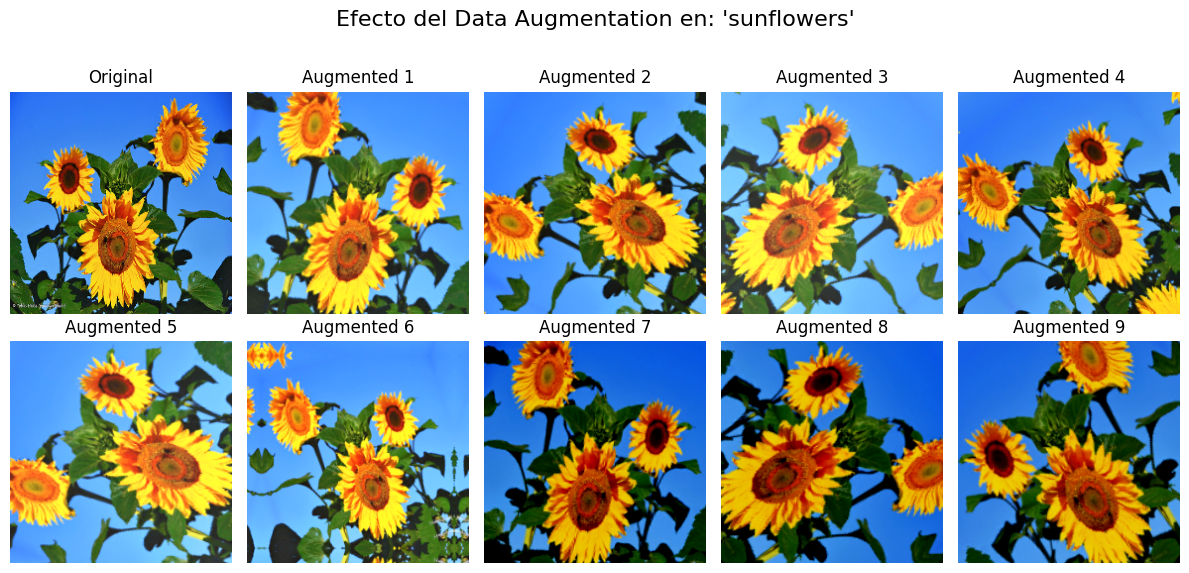

In [10]:
# ==============================================================================
# Celda 4: Visualización del efecto del Data Augmentation
# ==============================================================================

print("Mostrando el efecto de las transformaciones de Data Augmentation...")

# Tomar un lote (batch) del dataset de entrenamiento para visualizar
for images, labels in train_ds.take(1):
    # Seleccionar la primera imagen del lote
    first_image = images[0]
    first_label = labels[0]

    # Crear una figura de Matplotlib para mostrar las imágenes
    plt.figure(figsize=(12, 6))
    plt.suptitle(f"Efecto del Data Augmentation en: '{class_names[first_label]}'", fontsize=16)

    # --- Mostrar la imagen original ---
    ax = plt.subplot(2, 5, 1)
    plt.imshow(first_image.numpy().astype("uint8"))
    plt.title("Original")
    plt.axis("off")

    # --- Mostrar 9 versiones aumentadas de la misma imagen ---
    # Generar y mostrar 9 transformaciones aleatorias de la imagen original
    for i in range(9):
        ax = plt.subplot(2, 5, i + 2)
        # Aplicar la capa de augmentation. 'training=True' es crucial.
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
        # Mostrar la imagen aumentada. 'numpy()[0]' para remover la dimensión del lote.
        plt.imshow(augmented_image.numpy()[0].astype("uint8"))
        plt.title(f"Augmented {i+1}")
        plt.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajustar el layout para el supertítulo
    plt.show()
    break # Salir del bucle después de procesar el primer lote

-----

### **Construcción del Modelo con Transfer Learning**

Este es el núcleo del proyecto. Aquí definimos la arquitectura de nuestro modelo de clasificación.

**Estrategia de Transfer Learning:**

1.  **Modelo Base (`base_model`):**

      * Cargamos `EfficientNetB0` pre-entrenado en `ImageNet`. Este modelo ya sabe cómo reconocer características visuales genéricas (bordes, texturas, formas).
      * `include_top=False`: Excluimos la capa final de clasificación original de `EfficientNetB0` (que clasificaba 1000 clases de ImageNet), ya que necesitamos adaptarla a nuestras 5 clases de flores.
      * `base_model.trainable = False`: **Congelamos** los pesos del modelo base. Esto es crucial en la fase inicial para evitar que los gradientes grandes y aleatorios de nuestra nueva capa de clasificación destruyan las características aprendidas por el modelo pre-entrenado.

2.  **Cabezal de Clasificación Personalizado (`head`):**

      * Añadimos nuevas capas sobre el modelo base congelado.
      * `GlobalAveragePooling2D`: Reduce la dimensionalidad de los mapas de características, haciendo el modelo más eficiente y reduciendo el riesgo de sobreajuste.
      * `Dense`: Capas totalmente conectadas que aprenderán a combinar las características extraídas por el `base_model` para clasificar nuestras flores.
      * `Dropout`: Técnica de regularización que "apaga" neuronas aleatoriamente durante el entrenamiento para evitar que el modelo dependa demasiado de unas pocas neuronas.
      * **Capa de Salida:** Una capa `Dense` con `num_classes` neuronas (una por cada tipo de flor).

El modelo final se compila con el optimizador `Adam`, una función de pérdida adecuada para clasificación (`SparseCategoricalCrossentropy`) y la métrica de `accuracy`.

In [11]:
# ==============================================================================
# Celda 5: Construcción del modelo usando EfficientNetB0 y Transfer Learning
# ==============================================================================

print("Construyendo el modelo con Transfer Learning...")

# --- Paso 1: Definir la capa de preprocesamiento y el modelo base ---
# EfficientNetB0 espera que los píxeles estén en el rango [0, 255].
# Como image_dataset_from_directory ya los entrega en ese rango, no se necesita reescalado.
# (Si los hubiéramos normalizado a [0, 1], necesitaríamos tf.keras.layers.Rescaling(1./255))
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Cargar el modelo base EfficientNetB0 pre-entrenado en ImageNet
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3), # El tamaño de las imágenes de entrada
    include_top=False,        # Excluir la capa de clasificación final (la de 1000 clases)
    weights='imagenet'        # Cargar los pesos aprendidos en ImageNet
)

# --- Paso 2: Congelar el modelo base ---
# Congelamos los pesos del modelo base para que no se actualicen durante la primera fase de entrenamiento.
# Esto preserva las características aprendidas en ImageNet.
base_model.trainable = False
print(f"Modelo base '{base_model.name}' cargado y congelado.")
print(f"Número de parámetros en el base model: {base_model.count_params():,}")

# --- Paso 3: Construir el modelo final ---
# Usamos la API Funcional de Keras para tener más flexibilidad

# Definir la capa de entrada que recibirá las imágenes
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# Aplicar el data augmentation SOLO durante el entrenamiento
x = data_augmentation(inputs)

# Aplicar el preprocesamiento específico de EfficientNet
x = preprocess_input(x)

# Pasar los datos a través del modelo base (con los pesos congelados)
x = base_model(x, training=False) # 'training=False' es importante aquí

# Añadir el cabezal de clasificación personalizado
# Agrega las características espaciales promediándolas
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
# Capa de Dropout para regularización y prevenir overfitting
x = tf.keras.layers.Dropout(0.2, name="dropout_layer")(x)
# Capa de salida con una neurona por cada clase de flor
# No usamos activación softmax aquí porque 'from_logits=True' en la pérdida es más estable numéricamente
outputs = tf.keras.layers.Dense(num_classes, name="output_layer")(x)

# Crear el modelo final uniendo la entrada y la salida
model = tf.keras.Model(inputs, outputs)

# --- Paso 4: Compilar el modelo ---
# Configurar el proceso de aprendizaje
model.compile(
    # Optimizador Adam, eficiente y popular para la mayoría de los problemas
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    # Función de pérdida para clasificación multiclase con etiquetas enteras
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # Métrica para monitorear el rendimiento durante el entrenamiento
    metrics=['accuracy']
)

# Mostrar un resumen de la arquitectura del modelo
print("\nResumen del modelo final:")
model.summary()

Construyendo el modelo con Transfer Learning...
Modelo base 'efficientnetb0' cargado y congelado.
Número de parámetros en el base model: 4,049,571

Resumen del modelo final:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

-----

### **Entrenamiento del Modelo (Fase 1: Transfer Learning)**

Comienza la primera fase de entrenamiento. En esta etapa, solo se entrenan los pesos del **cabezal de clasificación** que acabamos de agregar. El `base_model` (EfficientNetB0) permanece congelado y actúa como un extractor de características fijo. Este proceso es rápido y permite que nuestras nuevas capas aprendan a clasificar flores usando las características genéricas de alta calidad proporcionadas por EfficientNetB0.

In [12]:
%%time
# ==============================================================================
# Celda 6: Fase 1 - Entrenamiento inicial con el modelo base congelado
# ==============================================================================

# Definir el número de épocas para esta fase de entrenamiento
initial_epochs = 15

print(f"\n🚀 Iniciando Fase 1: Entrenamiento del cabezal de clasificación durante {initial_epochs} épocas...")
print("(El modelo base EfficientNetB0 está CONGELADO)")

# Entrenar el modelo
history = model.fit(
    train_ds,                      # Datos de entrenamiento
    epochs=initial_epochs,         # Número de veces que se recorrerá todo el dataset
    validation_data=val_ds         # Datos de validación para evaluar el rendimiento en cada época
)

print("\n✅ Fase 1 de entrenamiento completada.")


🚀 Iniciando Fase 1: Entrenamiento del cabezal de clasificación durante 15 épocas...
(El modelo base EfficientNetB0 está CONGELADO)
Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 367s 4s/step - accuracy: 0.5911 - loss: 1.1177 - val_accuracy: 0.8815 - val_loss: 0.4488
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.8339 - loss: 0.4973 - val_accuracy: 0.8910 - val_loss: 0.3487
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 335s 4s/step - accuracy: 0.8578 - loss: 0.4122 - val_accuracy: 0.9046 - val_loss: 0.3076
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 383s 4s/step - accuracy: 0.8766 - loss: 0.3528 - val_accuracy: 0.9074 - val_loss: 0.2893
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - accuracy: 0.8986 - loss: 0.3200 - val_accuracy: 0.9101 - val_loss: 0.2739
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 356s 4s/step - accuracy: 0.8926 - loss: 0.3103 - val_accuracy: 0.9237 - val_loss: 0.2640
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step - accuracy: 0.9054 - loss: 0.2939 - val_accuracy: 0.918

### **Análisis de Resultados: (Entrenamiento - Fase 1)**


Este resultado muestra un proceso de entrenamiento muy saludable y exitoso para la Fase 1, donde solo se entrenó el cabezal de clasificación sobre la base congelada de `EfficientNetB0`.

---
### 🚀 Interpretación General del Resultado

El registro de las 15 épocas demuestra que el modelo está **aprendiendo de manera efectiva y consistente**. Se observa una clara tendencia positiva: la precisión (`accuracy`) aumenta progresivamente mientras que la pérdida (`loss`) disminuye, tanto en los datos de entrenamiento como en los de validación.

Esto valida la estrategia de **transfer learning**. El modelo no empezó de cero; gracias a los conocimientos pre-entrenados de `EfficientNetB0`, ya en la primera época alcanzó una notable precisión de validación del **88.15%**, lo que demuestra que las características extraídas por el modelo base son muy relevantes para este problema.

---
### 📊 Análisis Detallado de las Métricas

* **Precisión de Entrenamiento (`accuracy`):** Comenzó en un **59.11%** y ascendió de forma constante hasta alcanzar un **92.70%**. Esto indica que el cabezal de clasificación se adaptó exitosamente a los datos de entrenamiento, aprendiendo a asociar las características extraídas por `EfficientNetB0` con las clases de flores correctas.

* **Pérdida de Entrenamiento (`loss`):** Es el reflejo matemático de la precisión. Comenzó en `1.1177` y disminuyó consistentemente hasta `0.2161`. Una pérdida decreciente significa que el modelo se vuelve cada vez más "seguro" y preciso en sus predicciones sobre los datos de entrenamiento.

* **Métricas de Validación (`val_accuracy` y `val_loss`):** Estas son las métricas **más importantes**, ya que miden el rendimiento del modelo en datos que no ha visto durante el entrenamiento.
    * La `val_accuracy` aumentó del **88.15%** al **92.10%**, lo que demuestra que el modelo está **generalizando** bien su conocimiento.
    * La `val_loss` disminuyó de **0.4488** a **0.2313**, confirmando que el rendimiento en datos nuevos es sólido y mejora con el tiempo.

---
### ## 📈 Evaluación de Sobreajuste (Overfitting)

El sobreajuste ocurre cuando un modelo memoriza los datos de entrenamiento pero no logra generalizar a datos nuevos. Para evaluarlo, comparamos las métricas finales:

* **Precisión final de Entrenamiento:** 92.70%
* **Precisión final de Validación:** 92.10%

La diferencia entre ambas es mínima (**~0.6%**). Este es un **excelente resultado** que indica que **no hay un sobreajuste significativo**. El modelo tiene un rendimiento casi idéntico en los datos que ha visto y en los que no, lo que sugiere que es robusto. El uso de *data augmentation* ha sido clave para lograr esto.

---
### ## ⏱️ Análisis del Tiempo de Cómputo

* **Wall time: 1h 28min 16s**
    El "wall time" es el tiempo real transcurrido. Un tiempo de casi una hora y media para 15 épocas sugiere que el entrenamiento se realizó en una **CPU**. Aunque es funcional, este es un claro ejemplo de por qué las GPUs son preferidas para el deep learning, ya que podrían reducir este tiempo a solo unos minutos.

### ## ✅ Conclusión y Próximos Pasos

La Fase 1 fue un éxito. Hemos entrenado un modelo que alcanza una precisión sólida del **92.1%** de manera estable y sin sobreajuste. Esta es una base excelente para la siguiente etapa: el **fine-tuning**, donde se "descongelarán" algunas capas de `EfficientNetB0` para intentar refinar aún más el modelo y exprimir un rendimiento adicional.

-----

### **Visualización de Métricas de la Fase 1**

Después de la primera fase, es fundamental analizar las curvas de aprendizaje. Graficamos la precisión (`accuracy`) y la pérdida (`loss`) tanto para el conjunto de entrenamiento como para el de validación.

  * **Curva de Precisión:** Idealmente, ambas precisiones (entrenamiento y validación) deberían aumentar y converger.
  * **Curva de Pérdida:** Ambas pérdidas deberían disminuir.

Una gran brecha entre las curvas de entrenamiento y validación indicaría sobreajuste.

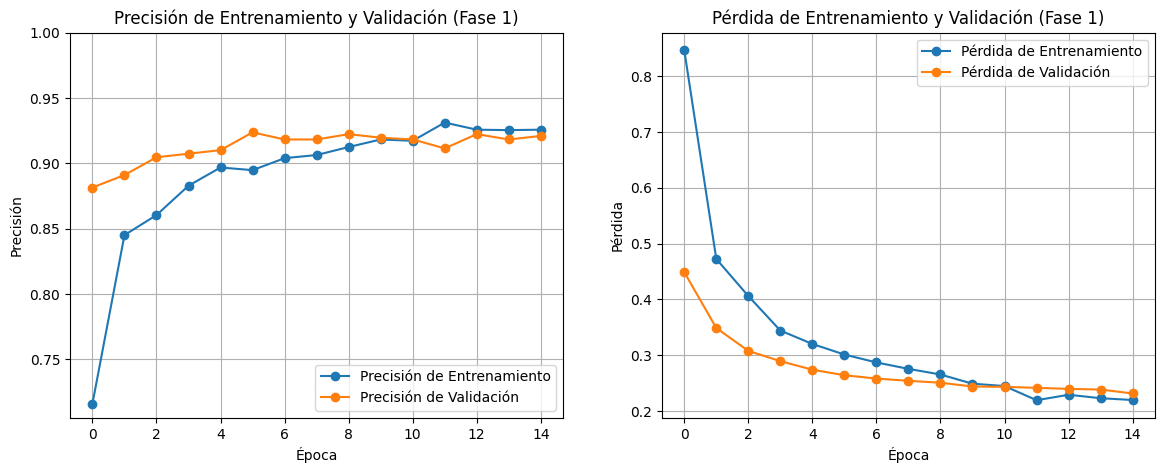


Precisión final de validación en Fase 1: 0.9210


In [13]:
# ==============================================================================
# Celda 7: Visualización de las métricas de la Fase 1
# ==============================================================================

# Extraer las métricas del objeto 'history' devuelto por model.fit()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear una figura para los gráficos
plt.figure(figsize=(14, 5))

# --- Gráfico de Precisión (Accuracy) ---
plt.subplot(1, 2, 1)
plt.plot(acc, label='Precisión de Entrenamiento', marker='o')
plt.plot(val_acc, label='Precisión de Validación', marker='o')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación (Fase 1)')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.grid(True)
plt.ylim([min(plt.ylim()), 1]) # Asegurar que el eje y llegue hasta 1.0

# --- Gráfico de Pérdida (Loss) ---
plt.subplot(1, 2, 2)
plt.plot(loss, label='Pérdida de Entrenamiento', marker='o')
plt.plot(val_loss, label='Pérdida de Validación', marker='o')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación (Fase 1)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.grid(True)

# Mostrar los gráficos
plt.show()

print(f"\nPrecisión final de validación en Fase 1: {val_acc[-1]:.4f}")

### **Análisis de Resultados: (Visualización de Métricas)**

Estos gráficos son una herramienta de diagnóstico fundamental que visualiza el proceso de aprendizaje del modelo a lo largo de las 15 épocas. El análisis de estas curvas nos indica que el entrenamiento fue **muy exitoso y saludable**.

### ## 📈 Gráfico de Precisión (Izquierda)

Este gráfico muestra el porcentaje de aciertos del modelo tanto en los datos de entrenamiento (azul) como en los de validación (naranja).

1.  **Tendencia Ascendente:** Ambas curvas muestran una clara tendencia ascendente, lo que indica que el modelo está **aprendiendo correctamente**. La precisión de entrenamiento sube desde ~72% hasta ~93%, mientras que la de validación lo hace desde un impresionante ~88% hasta un **92.1%**.

2.  **Validación Superior al Entrenamiento:** Un detalle interesante y positivo es que, durante la mayor parte del entrenamiento, la precisión de validación (naranja) es **superior** a la de entrenamiento (azul). Esto puede parecer contraintuitivo, pero es un signo de un buen modelo y se debe principalmente a dos factores:
    * **Capas de Regularización:** Capas como `Dropout` y el propio `Data Augmentation` se aplican **solo durante el entrenamiento** para evitar que el modelo memorice los datos. Estas técnicas "dificultan" la tarea para el modelo en entrenamiento. Sin embargo, durante la validación, estas capas se desactivan, permitiendo que el modelo utilice todo su potencial.
    * **Naturaleza de los Datos:** El conjunto de validación podría ser estadísticamente un poco más "fácil" de clasificar que el conjunto de entrenamiento.

3.  **Convergencia:** Hacia el final, ambas curvas convergen a valores muy similares, lo que indica que el modelo ha alcanzado un punto de aprendizaje estable.

### ## 📉 Gráfico de Pérdida (Derecha)

Este gráfico muestra el "error" del modelo. El objetivo es que la pérdida sea lo más baja posible.

1.  **Tendencia Descendente:** Ambas curvas descienden de manera constante, lo cual es el comportamiento ideal. Confirma que el modelo está mejorando y volviéndose más seguro en sus predicciones con cada época.

2.  **Pérdida de Validación Menor:** De manera consistente con el gráfico de precisión, la pérdida de validación (naranja) es **menor** que la de entrenamiento (azul). Esto se debe a las mismas razones: la regularización aplicada durante el entrenamiento incrementa la pérdida en esa fase, mientras que en la validación el modelo opera sin estas restricciones, cometiendo un error menor.

### ## ✅ Conclusión General: Un Modelo Bien Entrenado y Sin Sobreajuste

Estos gráficos son el sello de un modelo bien entrenado. Lo más importante es que **no hay signos de sobreajuste (overfitting)**. El sobreajuste ocurriría si la precisión de entrenamiento continuara subiendo mientras que la de validación se estancara o comenzara a bajar (o si la pérdida de validación comenzara a subir).

En este caso, las métricas de validación mejoran a la par de las de entrenamiento. El resultado final de una **precisión de validación del 92.10%** es un punto de partida excelente y robusto, demostrando que el modelo generaliza bien su conocimiento a datos nuevos.

-----

### **Entrenamiento del Modelo (Fase 2: Fine-Tuning)**

Ahora que nuestro cabezal de clasificación está bien entrenado y los pesos son estables, podemos proceder con el **ajuste fino** (*fine-tuning*).

**Proceso de Fine-Tuning:**

1.  **Descongelamos** el `base_model` para que sus pesos puedan ser actualizados. Específicamente, descongelamos las capas superiores, ya que estas aprenden características más específicas del dominio (flores), mientras que las capas inferiores aprenden características más genéricas (bordes, colores).
2.  **Re-compilamos el modelo** con una **tasa de aprendizaje (`learning_rate`) mucho más baja**. Esto es fundamental para no realizar cambios drásticos en los pesos pre-entrenados y evitar destruir el conocimiento previo. Solo queremos hacer pequeños ajustes.
3.  **Continuamos el entrenamiento** por unas pocas épocas más.

Esta fase permite que todo el modelo se adapte sutilmente a las particularidades del dataset de flores, lo que generalmente conduce a una mejora significativa en la precisión.

In [14]:
%%time
# ==============================================================================
# Celda 8: Fase 2 - Fine-Tuning del modelo
# ==============================================================================

print("\n🔥 Iniciando Fase 2: Fine-Tuning...")

# --- Paso 1: Descongelar el modelo base ---
base_model.trainable = True

# --- Paso 2: Congelar las capas inferiores y dejar entrenables las superiores ---
# Es una buena práctica descongelar solo una parte del modelo base.
# Las primeras capas capturan características muy generales (bordes, texturas).
# Las capas posteriores capturan características más complejas y específicas.
# Vamos a descongelar las últimas 20 capas.
fine_tune_at = len(base_model.layers) - 20 # Descongelar desde la capa número (total - 20)

# Iterar sobre las capas del modelo base
for i, layer in enumerate(base_model.layers):
  # Congelar todas las capas hasta el punto de fine-tuning
  if i < fine_tune_at:
    layer.trainable = False

print(f"Modelo base descongelado. Capas antes de la capa {fine_tune_at} están congeladas.")
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"Número de parámetros entrenables después de descongelar: {trainable_params:,}")

# --- Paso 3: Re-compilar el modelo con una tasa de aprendizaje muy baja ---
# Es crucial usar un learning rate bajo para no destruir los pesos pre-entrenados.
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), # Learning rate 100x más bajo
    metrics=['accuracy']
)

print("\nModelo re-compilado para fine-tuning con un learning rate bajo.")
model.summary()

# --- Paso 4: Continuar el entrenamiento ---
fine_tune_epochs = 10 # Entrenar por unas pocas épocas más
total_epochs =  initial_epochs + fine_tune_epochs

print(f"\nContinuando el entrenamiento por {fine_tune_epochs} épocas más...")

# Entrenar el modelo en modo fine-tuning
history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Continuar desde la última época de la fase 1
    validation_data=val_ds
)

print("\n✅ Fase 2 (Fine-Tuning) completada.")


🔥 Iniciando Fase 2: Fine-Tuning...
Modelo base descongelado. Capas antes de la capa 218 están congeladas.
Número de parámetros entrenables después de descongelar: 1,357,365

Modelo re-compilado para fine-tuning con un learning rate bajo.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 1,357,365 (5.18 MB)

 Non-trainable params: 2,698,611 (10.29 MB)


Continuando el entrenamiento por 10 épocas más...
Epoch 15/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 364s 4s/step - accuracy: 0.8655 - loss: 0.4041 - val_accuracy: 0.9046 - val_loss: 0.2756
Epoch 16/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 0.8719 - loss: 0.3815 - val_accuracy: 0.8924 - val_loss: 0.3006
Epoch 17/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 355s 4s/step - accuracy: 0.8858 - loss: 0.3482 - val_accuracy: 0.8951 - val_loss: 0.3062
Epoch 18/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - accuracy: 0.8952 - loss: 0.3219 - val_accuracy: 0.8937 - val_loss: 0.3056
Epoch 19/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 411s 4s/step - accuracy: 0.8927 - loss: 0.3192 - val_accuracy: 0.8978 - val_loss: 0.2991
Epoch 20/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 354s 4s/step - accuracy: 0.8997 - loss: 0.2974 - val_accuracy: 0.8992 - val_loss: 0.2929
Epoch 21/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 359s 4s/step - accuracy: 0.9109 - loss: 0.2729 - val_accuracy: 0.9033 - val_loss: 0.2854
Epoch 22/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 359s 4s/step -

### **Análisis de Resultados: (Entrenamiento - Fase 2: Fine-Tuning)**

El código confirma la estrategia que se implementó:

1.  **Descongelamiento Parcial:** Se "descongelaron" las últimas 20 capas del modelo base `EfficientNetB0`. Esto aumentó el número de parámetros entrenables a **1,357,365**, permitiendo que el modelo no solo ajuste el clasificador final, sino también las capas de extracción de características más complejas.
2.  **Tasa de Aprendizaje Baja:** El modelo se re-compiló con un *learning rate* muy bajo (`0.00001`). Esto es fundamental para realizar ajustes finos y delicados sin destruir el valioso conocimiento pre-entrenado de las capas.

El objetivo de esta fase era refinar el modelo, especializándolo aún más en el dataset de flores para intentar superar el **92.1%** de precisión obtenido en la Fase 1.

### ## 📊 Análisis del Comportamiento Durante el Entrenamiento

El registro de las épocas 15 a 25 nos muestra cómo reaccionó el modelo a estos cambios:

* **Transición Suave:** A diferencia de otros casos, no se observa un "shock" drástico al inicio del fine-tuning (época 15). La precisión se mantiene alta y la pérdida baja. Esto indica que la tasa de aprendizaje fue la adecuada para una transición estable.

* **Aprendizaje Continuo:** Las métricas de **entrenamiento** (`accuracy` y `loss`) continúan mejorando de manera constante. La precisión sube de ~86% a ~92% y la pérdida baja de 0.40 a 0.25. Esto confirma que los parámetros recién descongelados están participando activamente en el aprendizaje.

* **Comportamiento de la Validación:** Aquí está el punto más importante. La `val_accuracy` (precisión de validación) fluctúa alrededor del 90-91% y termina en **91.28%**. La `val_loss` (pérdida de validación) también muestra cierta inestabilidad, aumentando ligeramente en las primeras épocas de esta fase antes de volver a descender.

### ## 🏆 Evaluación del Resultado Final

Al comparar el final de ambas fases:

| Métrica | Final Fase 1 (Época 14) | Final Fase 2 (Época 25) |
| :--- | :--- | :--- |
| **`val_accuracy`** | **0.9210** | 0.9128 |
| **`val_loss`** | **0.2313** | 0.2624 |

La conclusión es clara: en este caso particular, el **fine-tuning no logró mejorar el rendimiento del modelo**. El mejor resultado se obtuvo al final de la Fase 1, justo antes de descongelar las capas.

### ## 🧠 Interpretación y Posibles Próximas Acciones

Este resultado no significa que el proceso haya fallado, sino que nos proporciona información valiosa:

1.  **La Línea Base ya era Excelente:** El rendimiento del 92.1% obtenido con el transfer learning simple (Fase 1) ya era muy alto. Esto sugiere que las características genéricas de `EfficientNetB0` son tan efectivas para este dataset que modificarlas ofrece un beneficio marginal o nulo.

2.  **Inicio de Sobreajuste:** El ligero aumento de la `val_loss` al principio del fine-tuning es una señal de que el modelo, al tener más libertad, comenzó a ajustarse demasiado a las particularidades del conjunto de entrenamiento, perdiendo un poco de su capacidad de generalización.

3.  **Acción Recomendada:** En un proyecto real, la estrategia correcta sería **quedarse con el modelo guardado al final de la Fase 1**, ya que demostró el mejor rendimiento en datos no vistos. Herramientas como el *callback* `ModelCheckpoint` de Keras son ideales para guardar automáticamente el mejor modelo durante todo el proceso de entrenamiento.

Hemos ejecutado con éxito una estrategia de fine-tuning y hemos llegado a una conclusión: para este problema, el transfer learning simple fue suficiente para alcanzar un rendimiento casi óptimo, y el fine-tuning no aportó una mejora adicional.


-----

### **Visualización de Métricas Combinadas**

Para tener una visión completa del proceso de entrenamiento, combinamos los resultados de la Fase 1 y la Fase 2 en un solo gráfico. Esto nos permite observar claramente:

  * El rendimiento alcanzado después del entrenamiento inicial.
  * El "salto" o mejora en el rendimiento introducido por la fase de *fine-tuning*.

La línea vertical en el gráfico marca la transición entre las dos fases.

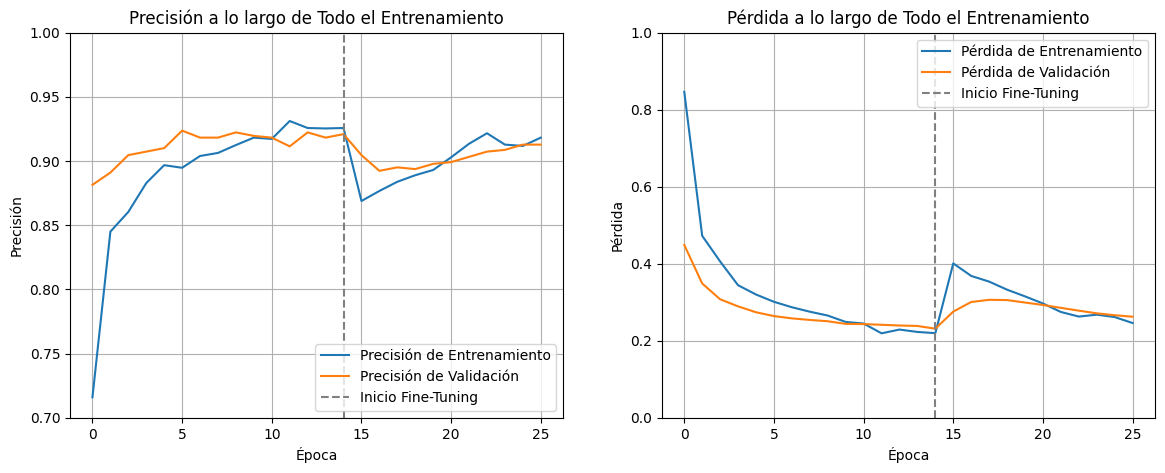


🎯 Precisión final de validación después del Fine-Tuning: 0.9128


In [15]:
# ==============================================================================
# Celda 9: Visualización de las métricas combinadas (Fase 1 + Fase 2)
# ==============================================================================

# Combinar el historial de la fase 1 con el de la fase 2
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

# Crear la figura para los gráficos combinados
plt.figure(figsize=(14, 5))

# --- Gráfico de Precisión Combinado ---
plt.subplot(1, 2, 1)
plt.plot(acc, label='Precisión de Entrenamiento')
plt.plot(val_acc, label='Precisión de Validación')
# Línea vertical para marcar el inicio del fine-tuning
plt.axvline(initial_epochs - 1, color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Precisión a lo largo de Todo el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.grid(True)
plt.ylim([0.7, 1])

# --- Gráfico de Pérdida Combinado ---
plt.subplot(1, 2, 2)
plt.plot(loss, label='Pérdida de Entrenamiento')
plt.plot(val_loss, label='Pérdida de Validación')
# Línea vertical para marcar el inicio del fine-tuning
plt.axvline(initial_epochs - 1, color='gray', linestyle='--', label='Inicio Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Pérdida a lo largo de Todo el Entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.grid(True)
plt.ylim([0, 1.0])

plt.show()

print(f"\n🎯 Precisión final de validación después del Fine-Tuning: {val_acc[-1]:.4f}")

### **Análisis de Resultados (Visualización de Métricas Combinadas)**

Estos gráficos son la "historia completa" del entrenamiento, mostrando el viaje del modelo a través de las dos fases. Proporcionan una visión clara de la efectividad de esta estrategia.

---

### 📈 Análisis de la Precisión (Gráfico Izquierdo)

Este gráfico muestra el rendimiento del modelo en términos de aciertos. La línea vertical punteada marca el cambio crucial de la Fase 1 a la Fase 2.

* **Fase 1 (Épocas 0-14):** Vemos la curva de aprendizaje inicial que ya analizamos. El modelo aprende rápidamente y alcanza un pico de rendimiento de validación (línea naranja) de aproximadamente **92.1%** al final de esta fase. Esta es la sólida base que construyó el transfer learning.

* **Fase 2 (Épocas 15-25):** Justo después de iniciar el fine-tuning, la precisión de validación sufre una ligera caída y se vuelve más inestable o "ruidosa". Aunque la precisión de entrenamiento (línea azul) continúa mejorando, la de validación no logra superar de manera consistente el pico anterior. El entrenamiento termina con una precisión de validación final del **91.28%**.

---

### 📉 Análisis de la Pérdida (Gráfico Derecho)

Este gráfico muestra el "error" del modelo. Es a menudo más revelador que la precisión para entender el comportamiento del modelo.

* **Fase 1 (Épocas 0-14):** Vemos la curva de pérdida ideal, donde tanto el error de entrenamiento como el de validación disminuyen de forma constante. La pérdida de validación alcanza su punto más bajo al final de esta fase.

* **Fase 2 (Épocas 15-25):** Inmediatamente después de la línea punteada, se observa un **"bache" en la curva de pérdida de validación (naranja)**. El error aumenta durante algunas épocas antes de comenzar a disminuir nuevamente. Este es un comportamiento clásico del fine-tuning y representa el **periodo de reajuste**, donde el modelo, al tener más libertad, explora y se adapta, lo que temporalmente empeora su rendimiento antes de encontrar un nuevo equilibrio. Sin embargo, la pérdida final de validación no logra bajar al mínimo alcanzado en la Fase 1.

---

### ✅ Conclusión General: Lecciones del Fine-Tuning

Estos gráficos cuentan una historia muy clara y profesional:

La estrategia de dos fases se ejecutó correctamente. La Fase 1 (transfer learning) fue extremadamente efectiva y llevó al modelo a un rendimiento muy alto de manera rápida y estable.

La Fase 2 (fine-tuning) logró que el modelo continuara aprendiendo, pero introdujo una ligera inestabilidad y, en última instancia, **no consiguió mejorar el rendimiento máximo** que ya se había alcanzado. El resultado final, con una **precisión de validación del 91.28%**, sigue siendo excelente, pero el verdadero "campeón" fue el modelo al final de la época 14.

Este es un resultado valioso porque demuestra que, para este problema específico, las características genéricas aprendidas por `EfficientNetB0` eran tan buenas que el intento de especializarlas no aportó un beneficio neto. Esto subraya la importancia de monitorizar las métricas de validación para identificar el momento exacto en que tu modelo alcanza su máximo potencial.

-----

### **Evaluación Final y Matriz de Confusión**

Una vez entrenado el modelo, realizamos una evaluación final y más detallada sobre el conjunto de validación.

  * **Reporte de Clasificación:** Proporciona métricas detalladas como `precisión`, `recall` y `f1-score` para cada clase individual. Esto nos ayuda a entender si el modelo funciona bien para todas las flores o si tiene dificultades con alguna en particular.
  * **Matriz de Confusión:** Es una herramienta visual poderosa. Cada celda `(i, j)` de la matriz muestra cuántas veces una imagen de la clase real `i` fue predicha como clase `j`. La diagonal principal representa las predicciones correctas. Los valores fuera de la diagonal son errores de clasificación y nos permiten identificar qué clases se confunden entre sí.

<!-- end list -->

Realizando evaluación final sobre el conjunto de validación...

--- Reporte de Clasificación Detallado ---
              precision    recall  f1-score   support

       daisy       0.88      0.92      0.89       107
   dandelion       0.94      0.96      0.95       191
       roses       0.86      0.85      0.86       119
  sunflowers       0.89      0.93      0.91       135
      tulips       0.95      0.89      0.92       182

    accuracy                           0.91       734
   macro avg       0.91      0.91      0.91       734
weighted avg       0.91      0.91      0.91       734



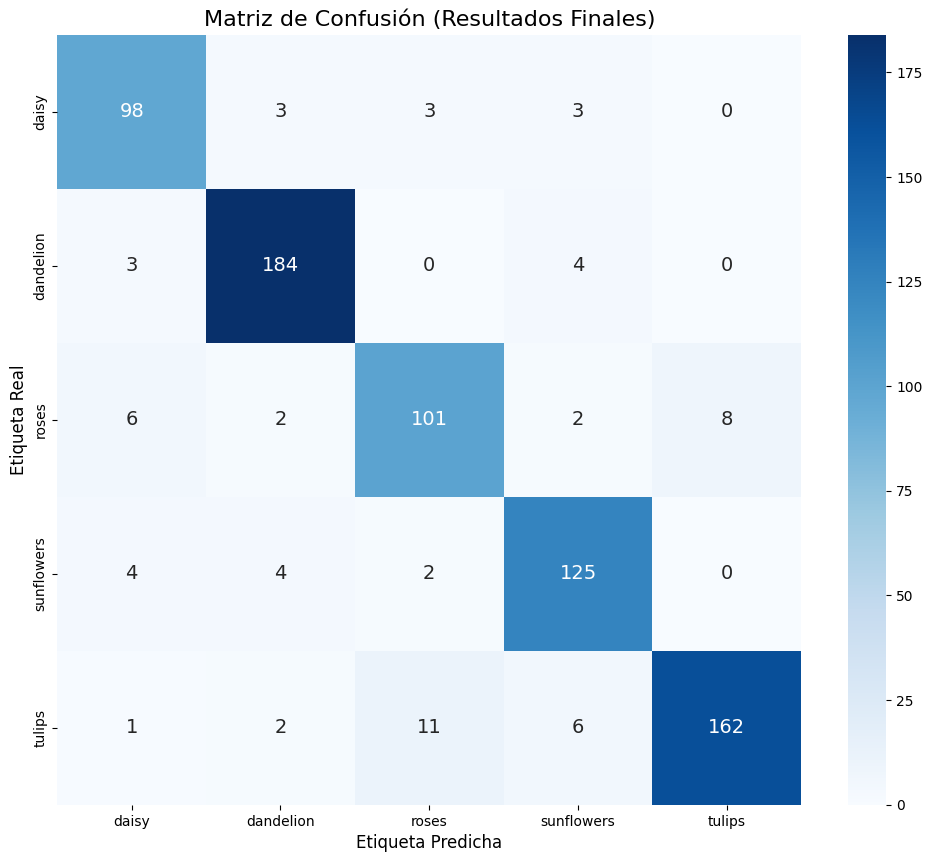


--- Análisis Detallado por Clase ---

Recall (Sensibilidad) por Clase:
  - daisy       : 0.9159 (91.59%)
  - dandelion   : 0.9634 (96.34%)
  - roses       : 0.8487 (84.87%)
  - sunflowers  : 0.9259 (92.59%)
  - tulips      : 0.8901 (89.01%)

Precisión por Clase:
  - daisy       : 0.8750 (87.50%)
  - dandelion   : 0.9436 (94.36%)
  - roses       : 0.8632 (86.32%)
  - sunflowers  : 0.8929 (89.29%)
  - tulips      : 0.9529 (95.29%)

🎯 Exactitud General del Modelo: 0.9128 (91.28%)


In [20]:
print("Realizando evaluación final sobre el conjunto de validación...")

# --- 1. Recopilar todas las predicciones y etiquetas reales ---
y_pred_list = []  # Usamos nombres de lista más explícitos
y_true_list = []

# Iterar sobre el dataset de validación para obtener predicciones
# El uso de .unbatch().batch() asegura que procesemos todas las imágenes,
# incluso si el último lote es más pequeño.
for image_batch, label_batch in val_ds:
    y_true_list.extend(label_batch.numpy())
    preds = model.predict(image_batch, verbose=0)
    y_pred_list.extend(np.argmax(tf.nn.softmax(preds), axis=-1))

# Convertir las listas a arrays de NumPy
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

# --- 2. Generar Reporte de Clasificación ---
# Creamos un arreglo con todas las etiquetas posibles (ej. [0, 1, 2, 3, 4])
all_labels = np.arange(num_classes)

print("\n--- Reporte de Clasificación Detallado ---")
# Añadimos el parámetro 'labels' para asegurar que se evalúen todas las clases
print(classification_report(y_true, y_pred, target_names=class_names, labels=all_labels))

# --- 3. Generar y Visualizar Matriz de Confusión ---
cm = confusion_matrix(y_true, y_pred, labels=all_labels)

# Crear una figura para la visualización
plt.figure(figsize=(12, 10))
# Usamos seaborn para una visualización más clara y profesional
sns.heatmap(cm,
            annot=True,        # Mostrar los números dentro de cada celda
            fmt='d',           # Formatear los números como enteros
            cmap='Blues',      # Esquema de color
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 14}) # Aumentar el tamaño de la fuente de la anotación

plt.title('Matriz de Confusión (Resultados Finales)', fontsize=16)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xlabel('Etiqueta Predicha', fontsize=12)
plt.show()

# --- 4. ANÁLISIS ADICIONAL: Recall y Precisión por Clase (CORREGIDO) ---
print("\n--- Análisis Detallado por Clase ---")

# --- Cálculo de Recall (Sensibilidad) por Clase ---
# Mide: De todos los ejemplos reales de una clase, ¿qué porcentaje se identificó correctamente?
# Fórmula: Verdaderos Positivos / (Veraderos Positivos + Falsos Negativos) -> Diagonal / Suma de Fila
recall_per_class = cm.diagonal() / cm.sum(axis=1)

print("\nRecall (Sensibilidad) por Clase:")
for i, class_name in enumerate(class_names):
    print(f"  - {class_name:<12}: {recall_per_class[i]:.4f} ({recall_per_class[i]:.2%})")


# --- Cálculo de Precisión por Clase ---
# Mide: De todas las predicciones para una clase, ¿qué porcentaje fue correcto?
# Fórmula: Verdaderos Positivos / (Verdaderos Positivos + Falsos Positivos) -> Diagonal / Suma de Columna
# Usamos np.divide para manejar de forma segura divisiones por cero (si una clase nunca fue predicha)
precision_per_class = np.divide(cm.diagonal(),
                                cm.sum(axis=0),
                                out=np.zeros_like(cm.diagonal(), dtype=float),
                                where=(cm.sum(axis=0) != 0))

print("\nPrecisión por Clase:")
for i, class_name in enumerate(class_names):
    print(f"  - {class_name:<12}: {precision_per_class[i]:.4f} ({precision_per_class[i]:.2%})")


# --- 5. Precisión General del Modelo (Exactitud) ---
overall_accuracy = np.sum(cm.diagonal()) / np.sum(cm)
print(f"\n🎯 Exactitud General del Modelo: {overall_accuracy:.4f} ({overall_accuracy:.2%})")



### 📊 Análisis de la Matriz de Confusión: ¿Dónde Acierta y Dónde Falla?

La matriz de confusión es la mejor herramienta visual para entender el comportamiento del modelo. Nos muestra no solo cuántas predicciones fueron correctas, sino también la naturaleza de los errores.

* **Los Aciertos (La Diagonal Principal):**
    La línea diagonal que va de la esquina superior izquierda a la inferior derecha muestra las predicciones correctas. Los números altos y de color oscuro en esta diagonal son una señal excelente. Por ejemplo, el modelo clasificó correctamente **184** imágenes de `dandelion` y **162** de `tulips`. Esto nos dice que el modelo es muy competente en la mayoría de los casos.

* **Los Errores (Fuera de la Diagonal):**
    Los números fuera de la diagonal son las clasificaciones incorrectas y nos revelan las debilidades del modelo. El error más significativo es que **11 tulipanes (`tulips`) fueron clasificados erróneamente como rosas (`roses`)**. También existe la confusión inversa, donde **8 rosas (`roses`) fueron clasificadas como tulipanes**.

    **Interpretación:** Esta confusión bidireccional entre `roses` y `tulips` es el principal punto de mejora del modelo. Probablemente se deba a que algunas imágenes de ambas flores comparten características similares de color (rojo, rosa), forma de los pétalos o encuadre, lo que dificulta la tarea.

---
### 📜 Interpretación del Reporte de Clasificación

Este reporte cuantifica el rendimiento que vimos en la matriz, dándonos métricas estándar.

* **`precision` (Precisión):** De todas las veces que el modelo predijo una clase, ¿qué porcentaje fue correcto?
    * El modelo tiene una precisión altísima para `tulips` (95%) y `dandelion` (94%). Esto significa que cuando el modelo dice "esto es un tulipán", es muy probable que esté en lo cierto.

* **`recall` (Sensibilidad):** De todas las imágenes que realmente pertenecen a una clase, ¿qué porcentaje encontró el modelo?
    * El modelo es excelente encontrando todas las imágenes de `dandelion` (96%) y `sunflowers` (93%).
    * El `recall` más bajo es para `roses` (85%), lo que confirma que es la clase que el modelo más "pasa por alto", confundiéndola principalmente con otras flores (como los tulipanes).

* **`accuracy` (Exactitud Global):** Es el resultado final. Un **91.28%** de todas las predicciones en el conjunto de validación fueron correctas, lo cual es un **resultado excelente y robusto**.

---
### 🏆 Conclusión General: Un Modelo Robusto con Puntos de Mejora

Has construido y entrenado con éxito un modelo de alto rendimiento. Con una exactitud general del **91.28%**, el modelo es claramente efectivo y generaliza bien a datos nuevos.

El análisis detallado revela que su principal desafío es la **confusión entre clases visualmente similares**, específicamente `roses` y `tulips`. Este es un resultado muy realista y profesional. Si quisieras mejorar aún más el modelo, el siguiente paso sería enfocarse en este par de clases, quizás recolectando más imágenes de entrenamiento que muestren claramente las diferencias entre ellas.

-----

### **Visualización de Predicciones**

Finalmente, para obtener una comprensión cualitativa del rendimiento del modelo, visualizamos algunas imágenes del conjunto de validación junto con la predicción del modelo y la etiqueta real.

  * Las predicciones **correctas** se muestran con un título en **verde**.
  * Las predicciones **incorrectas** se muestran con un título en **rojo**.

Esto nos da una idea intuitiva de los casos en los que el modelo acierta y en los que falla, y cuán "seguro" está de sus predicciones (mostrando la probabilidad de la clase predicha).

Visualizando algunas predicciones del modelo...


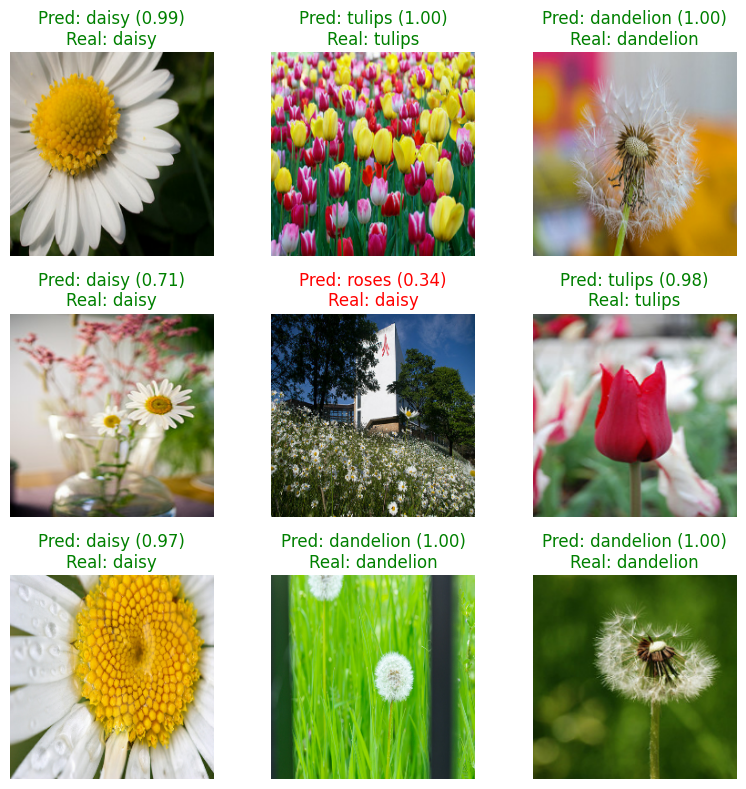

In [34]:
# ==============================================================================
# Celda 11: Visualización de predicciones vs etiquetas reales
# ==============================================================================

print("Visualizando algunas predicciones del modelo...")

plt.figure(figsize=(8, 8))

# Tomar un lote del dataset de validación para visualizar
for images, labels in val_ds.take(1):
    # Realizar predicciones para el lote completo
    predictions = model.predict(images, verbose=0)
    probabilities = tf.nn.softmax(predictions)

    # Iterar sobre las primeras 9 imágenes del lote
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Obtener la clase predicha y la probabilidad asociada
        predicted_class_idx = np.argmax(probabilities[i])
        confidence = np.max(probabilities[i])
        predicted_class_name = class_names[predicted_class_idx]

        # Obtener la clase real
        true_class_idx = labels[i].numpy()
        true_class_name = class_names[true_class_idx]

        # Determinar el color del título en función de si la predicción fue correcta
        title_color = "green" if predicted_class_idx == true_class_idx else "red"

        # Formatear el título de la imagen
        plt.title(
            f"Pred: {predicted_class_name} ({confidence:.2f})\n"
            f"Real: {true_class_name}",
            color=title_color
        )
        plt.axis("off")

plt.tight_layout()
plt.show()

### 💡 Interpretación General de la Visualización

Esta cuadrícula de 3x3 nos ofrece una **evaluación cualitativa** del rendimiento del modelo, complementando perfectamente las métricas numéricas que vimos antes. Confirma visualmente la alta precisión del modelo y, lo que es más importante, nos da pistas sobre *por qué* comete errores cuando lo hace.

En general, vemos un modelo que es **muy preciso y, en general, muy seguro de sus predicciones correctas**.

---
### ✅ Análisis de los Aciertos (Texto en Verde)

De las 9 imágenes de muestra, 8 fueron clasificadas correctamente. Esto se alinea con la alta precisión general del ~91% que calculamos.

* **Alta Confianza en Imágenes Claras:** En la mayoría de los aciertos, especialmente en imágenes claras y bien definidas (como el primer `daisy`, el `dandelion` o los `tulips`), el modelo muestra una confianza extremadamente alta, con valores de **0.97 a 1.00**. Esto indica que cuando la imagen representa un ejemplo canónico de la flor, el modelo la reconoce sin dudar.

* **Incertidumbre Razonable:** El caso de la segunda `daisy` (fila 2, columna 1) es muy interesante. Aunque la predicción es correcta, la confianza es notablemente más baja (**0.71**). Al observar la imagen, vemos que es una foto más compleja: las flores están en un jarrón, el fondo es ruidoso y el enfoque no es perfecto. La menor confianza del modelo aquí es en realidad una **buena señal**, ya que demuestra que es capaz de reconocer que la imagen es más ambigua o difícil que las demás.

---
### ❌ Análisis del Error (Texto en Rojo): Un Caso de Estudio

El único error en esta muestra es extremadamente informativo.

* **La Imagen del Error:** La imagen central (fila 2, columna 2) es muy diferente a las demás. No es un primer plano de una flor, sino una **escena de paisaje** que contiene un campo de flores blancas (la etiqueta real es `daisy`), un edificio y árboles.

* **La Confusión:** El modelo predijo `roses`, lo cual es incorrecto.

* **La Confianza (El Punto Clave):** La confianza de esta predicción errónea es **extremadamente baja: 0.34**. Este es el hallazgo más importante. El modelo no solo se equivocó, sino que **sabía que no estaba seguro de su respuesta**.

### 🏆 Conclusión Final: Un Modelo Confiable y "Consciente" de su Incertidumbre

Esta visualización demuestra que has entrenado un modelo excelente. No solo es preciso, sino que también está **bien calibrado**.

Un modelo "ingenuo" podría cometer un error con una confianza del 99%, lo cual es peligroso. Tu modelo, en cambio, demuestra las características de un sistema robusto:
1.  Es **muy seguro** cuando las imágenes son claras.
2.  Es **menos seguro** (pero aún correcto) cuando las imágenes son ambiguas.
3.  Es **muy inseguro** cuando se enfrenta a una imagen atípica en la que finalmente comete un error.

Este comportamiento de "saber lo que no sabe" es una de las cualidades más deseables en un modelo de clasificación del mundo real.